# Objective
- Demonstrate the effect of downsampling and matched cohorts have on outcomes

In [2]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

In [2]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/eval_5_cc/simsurv_func.py'>

# Data Generator

VARS:
- 0 = covid binary 90:10 (0:1)
- 1 = age numeric (0-100) uniform
- 2 = numeric (0-3) uniform
- 3 = numeric (0-1) uniform
- 4 = binary (10:90) (0:1)

- Additonal 5 non contributory variables
- Weak direct effect of COVID but still has noticable mean difference by 360 days
- Weak interaction effect with age

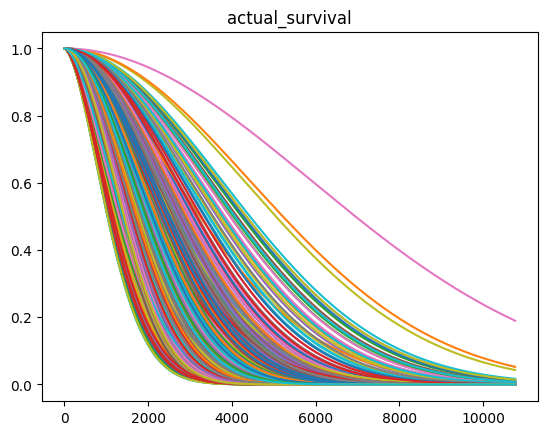

cens_calc: 0.0     
t_mean: 1811.452     
t_max: 10761.0


In [118]:
OUTPUTS = "outputs"
ALPHA = 3
ALPHA_F = "2 - .3*x_mat[:,0]"
# ALPHA_F = None
VAR_CLASS = [2,100,3,1,2]
VAR_PROB = [0.1, 0.5, 0.5, 0.2, 0.9]
# friedman 5 dimension function
# LAMBDA = "0.001 * np.exp(3+0.5*np.sin(np.pi*x_mat[:,0]*x_mat[:,1]) + np.power(x_mat[:,2],2) + 0.5*x_mat[:,3] + 0.25*x_mat[:,4])" 
LAMBDA = "np.exp(-8.4 + 0.2*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.01*np.log(x_mat[:,1])  + 0.001*np.power(x_mat[:,2],2) + 0.09*(x_mat[:,3]*x_mat[:,4]))" 

N = 2000
# T = 30
X_VARS = 10
CENS_SCALE = 5# 40
CENS_IND = False
T_CHNG = None

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                VAR_CLASS= VAR_CLASS,
                VAR_PROB = VAR_PROB,
                a = ALPHA,
                alpha_f=ALPHA_F,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False,
                T_CHNG=T_CHNG)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)

# plots moved to kpm by group
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

# Move average hazard per group below
# get unique x_mat
# x_unique = np.unique(x_mat, return_index=True, axis=0)
# sv_unique = sv_mat[x_unique[1],:]
# hz_unique = np.round(hz_mat[x_unique[1],:],5) 

# HR_unique = hz_unique[1]/hz_unique[0]
# # HR_times = np.arange(0,T,np.floor(T/4), dtype="int")
# HR_times = np.array((np.ceil(T.shape[0]/4) * np.array([1,2,3])), dtype="int")
# print(f"hazard rate 1 {hz_unique[1][HR_times]}")
# print(f"hazard rate 0 {hz_unique[0][HR_times]}")
# print(f"HR t-series = {HR_unique[HR_times]}")
# print(a)

In [119]:
# get check of survival probability in coivd vs non covid group
cov_msk = np.where(x_mat[:,0] == 1)
print(sv_mat[cov_msk[0],:].mean(0)[360])
print(sv_mat[~cov_msk[0],:].mean(0)[360])
# sv_mat[]

0.9234491643253423
0.9612737424698935


The initial function is 

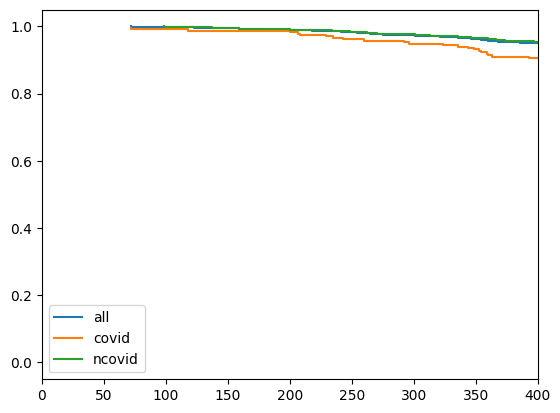

In [120]:
cov_mask = (x_mat[:,0]==1)
y_sk = ssf.get_y_sklearn(status, t_event)

kpm_all = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])
plt.step(kpm_all[0], kpm_all[1], label="all")
plt.step(kpm_cov[0], kpm_cov[1], label="covid")
plt.step(kpm_ncov[0], kpm_ncov[1], label="ncovid")
plt.xlim(0,400)
plt.legend()

# Transform scale day
- reduce number of computed timepoints

In [128]:
# TT_SCALE = 10
# tt_sc = t_event.copy()
# y_stat = t_event.copy()
# tt_sc = np.ceil(tt_sc/TT_SCALE)
TT_ADJ = 430
TT_SCALE = 60
tt_ind = t_event.copy()
y_stat = t_event.copy()
tt_ind[tt_ind>= TT_ADJ] = TT_ADJ
tt_sc = np.ceil(tt_ind/TT_SCALE)

y_stat[tt_ind >= TT_ADJ] = 0
y_stat[tt_ind < TT_ADJ] = 1

In [133]:
print(f"{TT_ADJ} day cases")
print(f"covid events {y_stat[cov_mask].sum()}")
print(f"covid cases {y_stat[cov_mask].shape[0]}")
print(f"ncov events {y_stat[~cov_mask].sum()}")
print(f"ncov cases {y_stat[~cov_mask].shape[0]}")

430 day cases
covid events 26.0
covid cases 233
ncov events 90.0
ncov cases 1767


- This is about the same proportions that we see in the Premier data.
only about 10% of cases are covid and of those we only see ~10% have events.
- In total only ~5% of the obs have events

## Data Prep

In [138]:
# get the event,time and the covariates data
y_sk = ssf.get_y_sklearn(y_stat, tt_sc)
x_sk = train.iloc[:,2:]

# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)

b_te_x = ssf.get_bart_test(x_sk, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

## KPM of tranformed

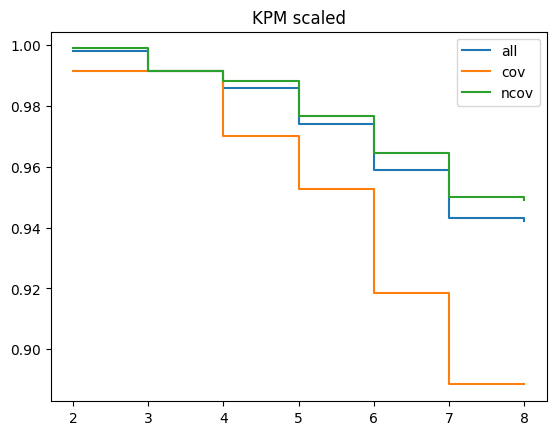

In [144]:
kpm_adj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])

plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post")
plt.title("KPM scaled")
plt.legend()

# BART

- Train bart model
- Split rules are defined by var type
    - the first var is now time and is always continuous
    - the extra 5 vars are continuous

In [139]:
# BART
M = 200 # number of trees
DRAWS = 200
TUNE = 200
CORES = 6
SPLIT_RULES = [
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule,
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule()
]

with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, 
                        draws=DRAWS, 
                        tune =TUNE, 
                        cores=CORES,
                        compute_convergence_checks=False,
                        discard_tuned_samples=True
                        )

with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])



Only 200 samples in chain.
Multiprocess sampling (6 chains in 6 jobs)
PGBART: [f]


Sampling 6 chains for 200 tune and 200 draw iterations (1_200 + 1_200 draws total) took 500 seconds.
Sampling: [f, y_pred]


In [141]:
# posterior objective
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

- Transform the output to survival values and times using the trained data
- Main vars
    - bart_sv_val 
    - bart_sv_t
- Fill in times that are not int the training dataset

In [196]:
# transform to survival
# fill times
t_min = np.unique(b_tr_t).min()
t_fill = np.arange(t_min)
val_fill = np.ones(t_fill.shape)
val_fill = np.repeat(val_fill, x_sk.shape[0]).reshape(x_sk.shape[0],val_fill.shape[0])

bart_sv_fx = ssf.get_sv_fx(pp, x_sk)
bart_sv_val = np.hstack([val_fill, bart_sv_fx])

bart_sv_t = np.unique(b_tr_t)
bart_sv_t = np.hstack([t_fill, bart_sv_t])

## Posterior Predictive Plot
- posterior predictive check on training samples

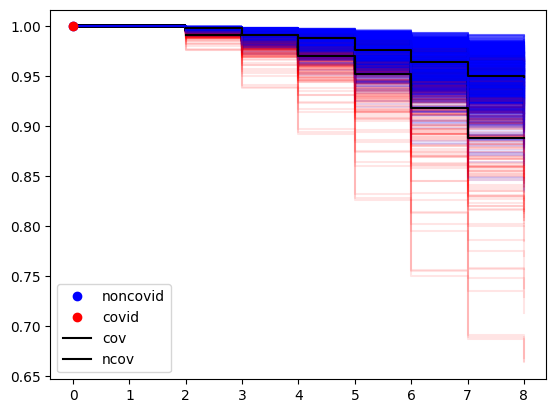

In [227]:
# Plot the posterior predictions
for r in np.arange(0, bart_sv_val.shape[0]):
    if x_mat[r,0] == 1:
        col = "red"
        lab="covid"
    else:
        col = "blue"
        lab="noncovid"
    plt.step(bart_sv_t, bart_sv_val[r,:], alpha=0.1, color=col, where="post")
plt.plot(0,1, "bo", label="noncovid")
plt.plot(0,1, "ro", label="covid")

plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post", color="black")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post", color="black")
plt.legend()

Predicted distribution of the training dataset 


## Plot true vs predicted SV probs

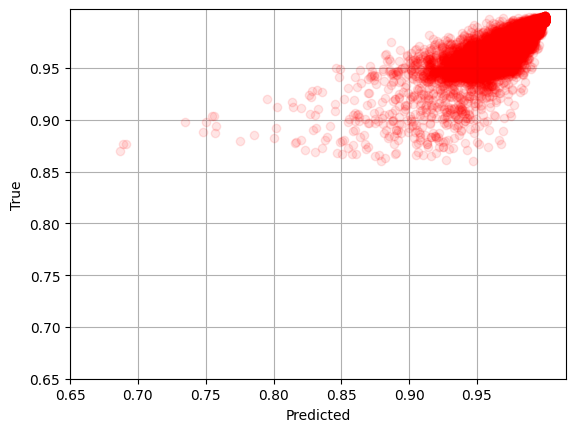

In [247]:
# get sv true
t_msk = np.array(np.arange(0,np.ceil(TT_ADJ/TT_SCALE) + 1) * TT_SCALE, dtype="int")
sv_true_t = sv_mat[:,t_msk]
t_len = len(t_msk)

assert sv_true_t.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(bart_sv_val[i,1:-1], sv_true_t[i,1:-1],"ro", alpha=0.1)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(0.65,1, 0.05))
plt.yticks(np.arange(0.65,1, 0.05))
plt.grid(visible="true")

1-1 plot indicates generally the predictions follow the Expected SV values. There is possibly a slight downward biasis in the predicted values, but this might be due to the underlying sample rather than a poorly trained model.

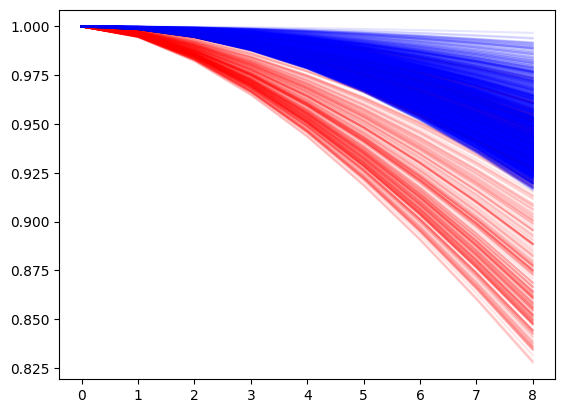

In [257]:

for i in np.arange(0,sv_true_t.shape[0]):
    if x_mat[i,0] == 1:
        col = "red"
        lab="covid"
    else:
        col = "blue"
        lab="noncovid"
    plt.plot(bart_sv_t, sv_true_t[i,:], color = col, alpha=0.1)

Looking at the true SV plot scaled and cropped we can see that we would expect a few patients to have a reduced sv value to ~0.82, the 

# COX
- Check how the COX model performs

In [237]:
# check cph
cph = sks.linear_model.CoxPHSurvivalAnalysis().fit(x_sk, y_sk)
print(f"exp coef: {np.exp(cph.coef_)}")

cph_sv = cph.predict_survival_function(x_sk)
cph_sv = np.array([fx(fx.x) for fx in cph_sv])

# we can reuse val_fill from above
cph_sv_val = np.hstack([val_fill, cph_sv])

# cph_sv_val=np.hstack([np.repeat(1,cph_sv.shape[0]).reshape((cph_sv.shape[0],1)), cph_sv])

exp coef: [2.40077152 1.0075705  0.84494021 1.91174373 1.10660659 0.67167219
 1.04169248 0.90086605 1.51793181 0.85666355]


- The exp coef (HR) seems to indicate some spurious associations generated from the data. The exp coef shouldn't be interpreted as direct HR since we know that the DGP includes complex nonlinear and non-proportional hz. 
- The last 5 variables, which should all be near 1, seem to be not estimated correctly, with var 9 being a large HR.

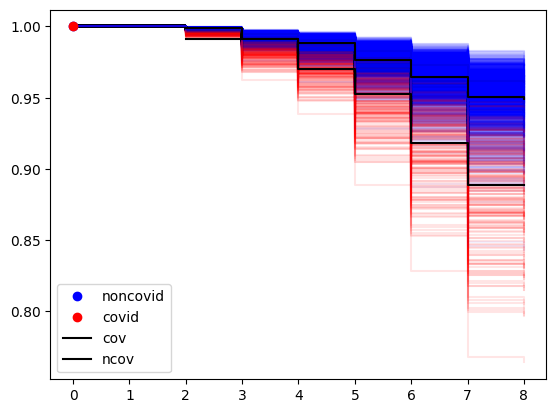

In [238]:
# cph_sv2 = np.hstack([np.repeat(1,cph_sv.shape[0]).reshape(cph_sv.shape[0],1), cph_sv[:, :]])
for i in np.arange(0, cph_sv_val.shape[0]):
    if x_mat[i,0] == 1:
        col = "red"
        alp = 0.1
    else:
        col = "blue"
        alp = 0.05
    plt.step(bart_sv_t, cph_sv_val[i,:], color=col, alpha=alp, where="post")
plt.plot(0,1, "bo", label="noncovid")
plt.plot(0,1, "ro", label="covid")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post", color="black")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post", color="black")
plt.legend()
# sv_true_t

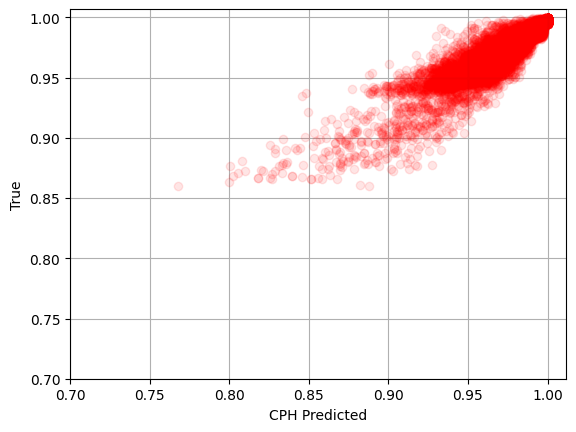

In [242]:
assert sv_true_t.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(cph_sv_val[i, 1:-1], sv_true_t[i,1:-1],"ro", alpha=0.1)
    # plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)

plt.xlabel("CPH Predicted")
plt.ylabel("True")
plt.xticks(np.arange(0.7,1, 0.05))
plt.yticks(np.arange(0.7,1, 0.05))
plt.grid(visible=True)

- Similar to the bart plot the predicted tend to be biased lower than the the Expected by the GDP. I would assume this has more to do with the random draw of the data more than the ability to fit the model

Text(0, 0.5, 'cph')

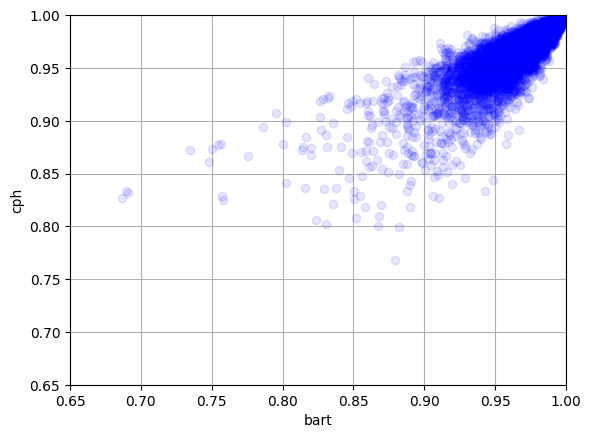

In [252]:
assert cph_sv_val.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    # plt.plot(cph_sv_val[i, 1:-1], sv_true_t[i,1:-1],"ro", alpha=0.1)
    plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)
plt.grid(visible=True)
plt.xlim(.65,1)
plt.ylim(.65,1)
plt.xlabel("bart")
plt.ylabel("cph")

The comparison of bart and cox predictions demonstrate BART has a few outliers that are decreased SV probability

# Metrics
- C-INDEX
- TD-AUC
- Brier Score

In [258]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [266]:
# set up hazards to use
shp1,shp2,shp3 = pp.posterior_predictive["mu"].values.shape
shp4 = x_sk.shape[0]
shp5 = np.unique(b_tr_t).shape[0]

bart_hz1 = pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
bart_chz1 = np.cumsum(bart_hz1, axis=1)

cph_chz = cph.predict_cumulative_hazard_function(x_sk)
cph_chz = np.array([fn(fn.x) for fn in cph_chz])


In [267]:
# c-index at distinct times
for i in np.arange(chz1.shape[1]):
    ci = concordance_index_censored(y_sk["Status"], y_sk["Survival_in_days"], bart_hz1[:,i])
    print(f"bart cindex {i}: {ci}")

for i in np.arange(cph_chz.shape[1]):
    ci = concordance_index_censored(y_sk["Status"], y_sk["Survival_in_days"], cph_chz[:,i])
    print(f"cph cindex {i}: {ci}")


bart cindex 0: (0.8113612100041543, 181637, 42230, 0, 3768)
bart cindex 1: (0.816122965868127, 182703, 41164, 0, 3768)
bart cindex 2: (0.8153144500976026, 182522, 41345, 0, 3768)
bart cindex 3: (0.8169806179561973, 182895, 40972, 0, 3768)
bart cindex 4: (0.8137108193704298, 182163, 41704, 0, 3768)
bart cindex 5: (0.8111780655478477, 181596, 42271, 0, 3768)
bart cindex 6: (0.8103181799907981, 181403, 42463, 1, 3768)
cph cindex 0: (0.6246923396480947, 139847, 84018, 2, 3768)
cph cindex 1: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 2: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 3: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 4: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 5: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 6: (0.6246968065860533, 139849, 84018, 0, 3768)


C-index indicates that the bart model performs superior to CPH. 

# time-auc

In [316]:
dy8_msk = np.where(y_sk["Survival_in_days"] == 8)
# np.where(y_sk["Status"][dy8_msk[0]] == True)
y_skauc = y_sk.copy()
# y_skauc = y_skauc[~dy8_msk[0]]
# tmp_sk = y_skauc[0]
y_skauc[0]["Survival_in_days"] = 9
y_skauc[0]["Status"] = True
# tmp_sk = tmp_sk.reshape(1,)
# y_skauc = np.concatenate([y_skauc, tmp_sk])


In [294]:
cph_chz.shape
bart_hz1.shape
bart_sv_t

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [321]:

cph_cda = cumulative_dynamic_auc(
    survival_train=y_skauc, 
    survival_test=y_skauc, 
    estimate=cph_chz[:,:6], 
    times=bart_sv_t[2:8]
)

brt_cda = cumulative_dynamic_auc(
    survival_train=y_skauc, 
    survival_test=y_skauc, 
    estimate=bart_hz1[:,:6], 
    times=bart_sv_t[2:8]
)

print(f"BART: {brt_cda}")
print(f"CPH: {cph_cda}")

BART: (array([0.9127004 , 0.83687817, 0.84578745, 0.81411902, 0.8012602 ,
       0.81778479]), 0.8208741710771652)
CPH: (array([0.64003006, 0.55854172, 0.61934946, 0.61679632, 0.61771663,
       0.62659764]), 0.614208261428285)


# Integrated Brier score

In [25]:
# bart_sv_brier = ssf.get_sv_fx(pp, x_sk)

In [330]:
cph_sv2 = np.hstack([np.repeat(1,cph_sv.shape[0]).reshape(cph_sv.shape[0],1), cph_sv[:, :]])
bart_ibs = integrated_brier_score(y_sk, y_sk, bart_sv_val[:, 6:8], bart_sv_t[6:8])
cph_ibs = integrated_brier_score(y_sk, y_sk, cph_sv_val[:, 6:8], bart_sv_t[6:8])

print(f"bart brier: {bart_ibs}")
print(f"cph brier: {cph_ibs}")

bart brier: 0.043345967021582874
cph brier: 0.045859387588214


- BART is better across all 3 metrics. In both C-index and AUC bart performes significantly better. In Brier Score Bart only performs slightly better, but this is to be expected, since the variance of sv times is relatively small and both models deviate little from the KPM estimate.
- Of note the AUC is calculated by switching one censored obs at the max time to True and 1 + max. This would adjust the AUC slightly at this time point, which is why we don't report AUC for the last tp
    - The adjust to AUC is minimal.

 

## RMSE and BIAS

In [331]:
def get_metrics(f_t, f, times, quants = np.array([0.1, 0.25, 0.5, 0.75, 0.9])):
    f_t = np.matrix(f_t)[:,times]
    f = np.matrix(f)[:, times]

    rmse = np.round(np.sqrt(np.mean(np.power(f_t - f, 2), axis=0)), 4)
    bias = np.round(np.mean(f_t - f, axis = 0), 4)
    
    return rmse, bias


In [332]:
bart_met =  get_metrics(sv_true_t, bart_sv_val, times = [2,3,4,5,6,7,8])
cph_met = get_metrics(sv_true_t, cph_sv_val, times = [2,3,4,5,6,7,8])


print(f"BART RMSE: {bart_met[0]}")
print(f"CPH RMSE: {cph_met[0]}")
print(f"BART BIAS: {bart_met[1]}")
print(f"CPH BIAS: {cph_met[1]}")


BART RMSE: [[0.003  0.0054 0.0087 0.0131 0.0191 0.0246 0.0277]]
CPH RMSE: [[0.0036 0.0039 0.0065 0.0082 0.0125 0.0178 0.0186]]
BART BIAS: [[-0.0016 -0.0014 -0.0021 -0.0002  0.003   0.0035 -0.0067]]
CPH BIAS: [[-0.0026 -0.0015 -0.0033 -0.0005  0.0035  0.0069 -0.0062]]


- RMSE and BIAS are minimal for both models. This would be assumed to be due to the relatively high SV probability displayed at the end timepoints

# BART VAR EVAL
- Use PDP to evaluate variables
- Compare to the True difference expected from the model

In [ ]:
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

/home/twj8/.local/lib/python3.10/site-packages/pymc_bart/utils.py:778: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]


(array([ 0, 10,  5,  2,  6,  8,  4,  1,  9,  3,  7]),
 array([<AxesSubplot:xlabel='covariables', ylabel='importance'>,
        <AxesSubplot:xlabel='number of covariables', ylabel='R²'>],
       dtype=object))

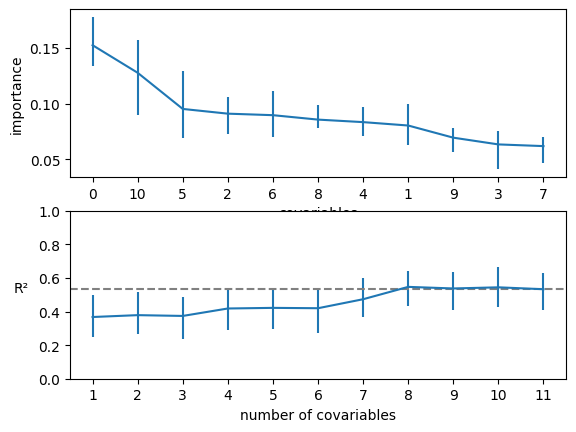

In [333]:
pmb.plot_variable_importance(
    idata=bdata,
    bartrv=f,
    X=b_tr_x,
    samples=300
)

- Variable importance doesn't seem to apply very well to this model
- Use PDPs for better evaluation
- We expect a small effect of COVID, larger effect of AGE and a combined effect of COVID and AGE. The other 3 variables should have a small effect, but may not be noticeable in this sample. The last 5 variables should have no effect



In [335]:
LAMBDA

'np.exp(-8.4 + 0.2*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.01*np.log(x_mat[:,1])  + 0.001*np.power(x_mat[:,2],2) + 0.09*(x_mat[:,3]*x_mat[:,4]))'

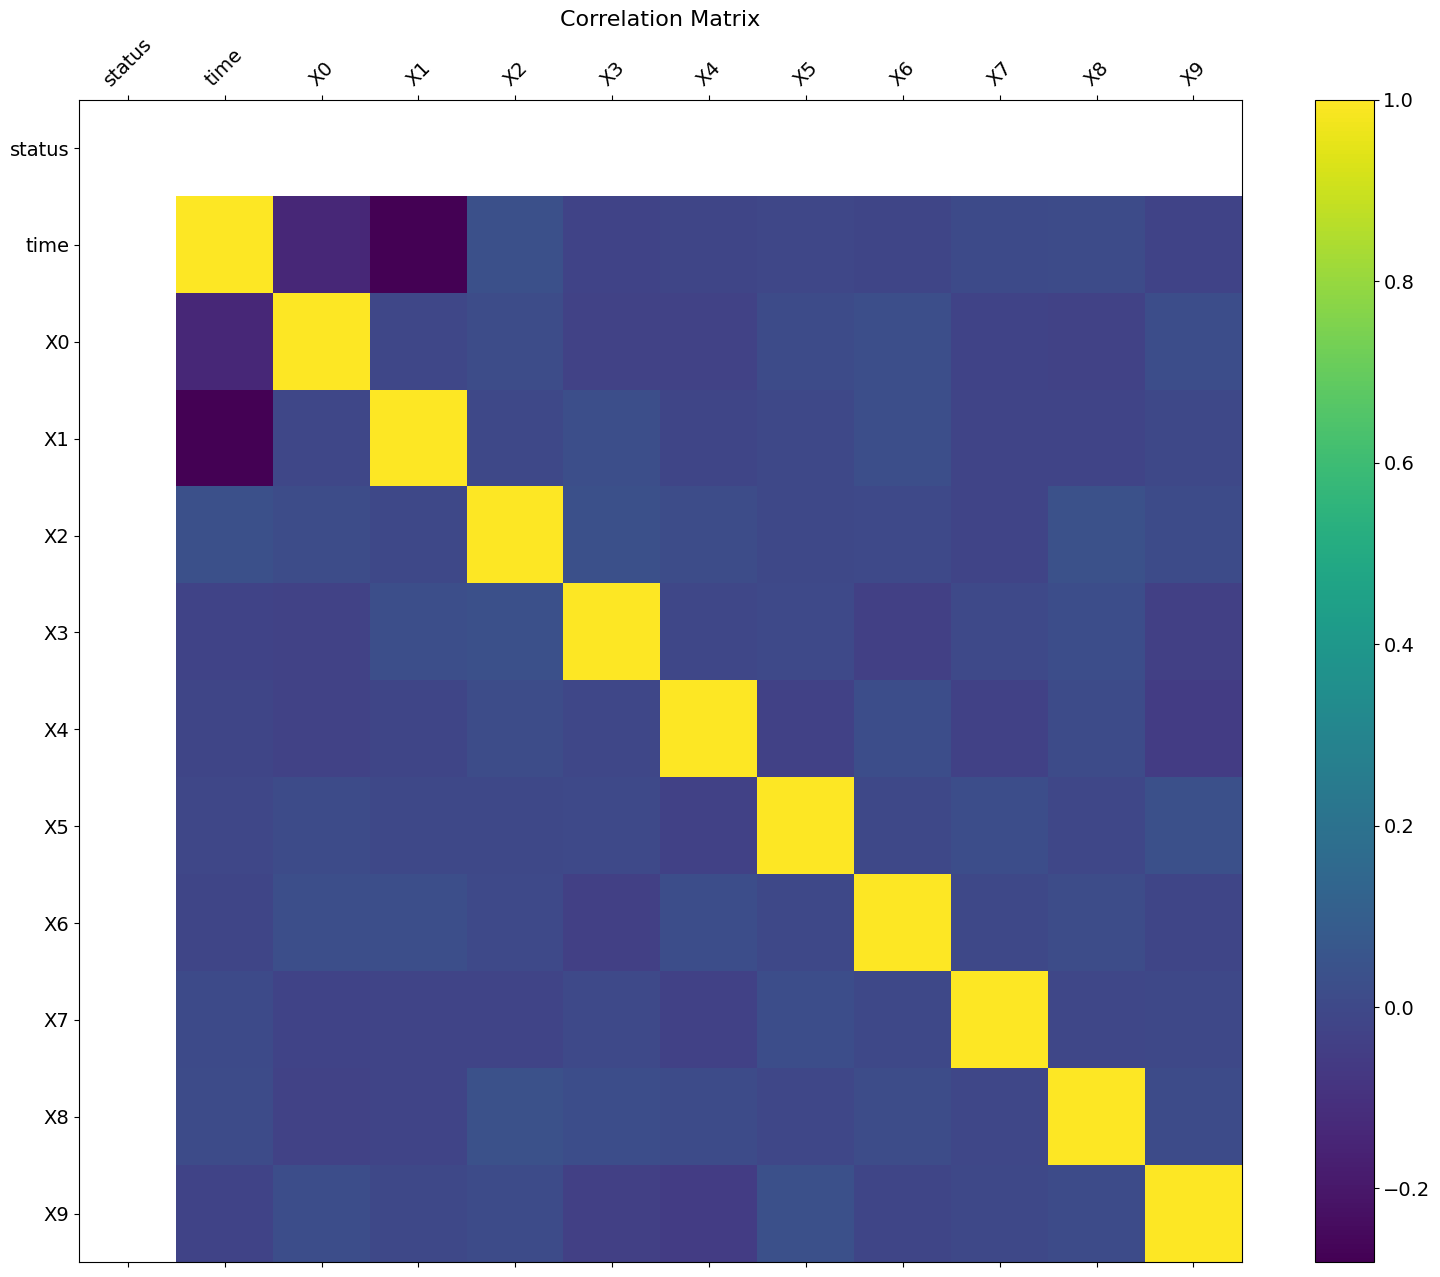

In [334]:
# Feature correlation plots
fm = plt.figure(figsize=(19, 15))
plt.matshow(train.corr(), fignum=fm.number)
plt.xticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The correlation plot demonstrates relatively how associated each variable is with the event time

## PDP 

- Below is a PDP function to compute a pdp for a give variable (in the context of sv). This function sets up the data and a call to the BART model to return posterior predictive in following step.
- Since these are all continuous variables, it is required to specify the values to compute PDP on for the given var.


Functions

In [433]:
# fdps for each var taking high and low value

def get_pdp(dtst, VAR, TIMES, VAL=[0.25,0.5,0.75,], SAMPLE=False, RN=100):
    # get a mask for subset of obs
    p_idx = np.where(dtst[:,0] == TIMES)
    pdp = dtst[p_idx[0],:]
    t_val = TIMES[0]
    # sample 
    if SAMPLE:
        tmp = dtst[np.where(dtst[:,0]==t_val)[0],:]
        # print(tmp.shape)
        rn_idx = np.random.choice(np.arange(0,tmp.shape[0]), RN, replace=False)
        pdp = tmp[rn_idx,:]
        # pdp = np.vstack([pdp]*len(TIMES))
        pdp = np.repeat(pdp, len(TIMES), axis=0)
        # print(pdp)
        pdp[:,0] = np.asarray(np.tile(TIMES, RN)).reshape(RN*len(TIMES),1)
        
    # make the pdp dataset
    rep = len(VAL)
    pdp_stack = np.vstack([pdp]*rep)
    val = np.quantile(np.asarray(pdp[:,VAR]), VAL)
    pdp_stack[:,VAR] = np.repeat(val, pdp.shape[0]).reshape(pdp_stack.shape[0],1)
    
    if SAMPLE:
        # pdp_stack is the pdp dataset and pdp is just to return the size of a single iteration of the pdp for sv_fx generation
        return pdp_stack, int(pdp_stack.shape[0]/len(TIMES)), len(TIMES)
    return pdp_stack, int(pdp_stack.shape[0]/len(TIMES)), len(TIMES)

def get_sv_fx(pp, r0, r1):
    p0 = pp.posterior_predictive["mu"].values.shape[0]
    p1 = pp.posterior_predictive["mu"].values.shape[1]
    p2 = pp.posterior_predictive["mu"].values.shape[2]
    pp_post = pp.posterior_predictive["mu"].values.reshape(p0*p1, p2).mean(axis=0).reshape(r0, r1)
    sv = (1-pp_post).cumprod(axis=1)
    return sv

def svplot(sv, tpt, brkpnt, qnt=[0.0275, 0.975], val=None):
    # Plots the SV points for each and Variance
    # Baseline is always the first Value
    istrt = 0
    shift = -.05
    for idx, iend in enumerate(brkpnt):
        qtmp = np.quantile(sv[istrt:iend,], [qnt[0],qnt[1]], 0)
        ptmp = sv[istrt:iend,].mean(0)
        qtmp = np.abs(qtmp - ptmp)
        tpt2 = [xi+shift for xi in tpt]
        plt.errorbar(x=tpt2, y=ptmp, yerr = qtmp, fmt="o", alpha=0.3, label=f"Val:{val[idx]}", capsize=10)
        istrt = iend
        shift += 0.05
    plt.legend()


- Gets the pdp from a sample of the dataset

Sampling: [f, y_pred]


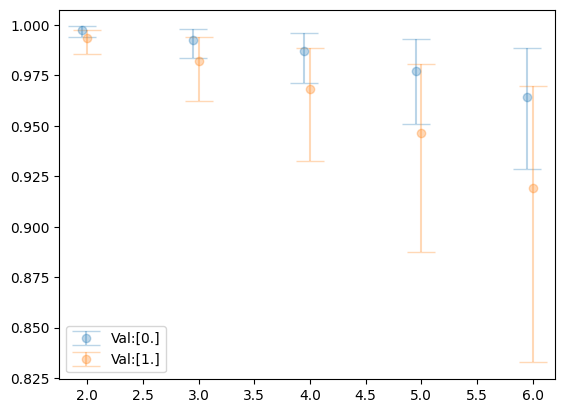

In [434]:
VAR=1
TIMES = [2,3,4,5,6]
RN = 500
VAL = [0,1]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

Compare to a sample of 1000 patients

Sampling: [f, y_pred]


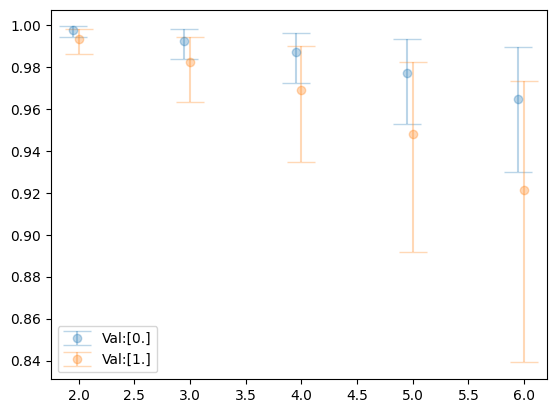

In [435]:
VAR=1
TIMES = [2,3,4,5,6]
RN = 1000
VAL = [0,1]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)# brk points is the number of patients in each set (could be automated)

- the larger sample doesn't make any significant changes too the plots

## Difference Between Exposures

In [436]:
def get_diff_avg(sv, BRKPNT):
    idx_refst = 0
    idx_refen = RN
    mean = []
    qt = []
    for idx,brk in enumerate(BRKPNT):
        diff = sv[brk:BRKPNT[idx+1]] - sv[idx_refst:idx_refen]
        d_mn = diff.mean(0)
        d_qt = np.quantile(diff, [0.0275, 0.975],0)
        # print(d_mn.shape)
        mean.append(d_mn)
        qt.append(d_qt)
        if BRKPNT[idx+1] == BRKPNT[-1]:
            break
    return mean, qt
# bart_sv_fx

def plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=None, TITLE=None):
    # ax,fig = plt.figure(diff_mn[0].shape[1])
    # color = ["ro","bo"]
    for idx, set in enumerate(diff_mn):
        print(set.shape)
        x = np.arange(0,set.shape[0])
        err = np.abs(diff_qt[0] - diff_mn[0])
        plt.errorbar(TIMES, set, yerr=err, alpha=0.3, fmt="o", label=f"diff {LABEL[idx]}")
    plt.legend()
    plt.title(f"Diff from Ref: {TITLE}")

def get_true_sv(lmbda, a=None, alpha_f=None, pdp_l=None, TIMES=None, scale=10):
    # if alpha_f is None:
    #     aaa = np.repeat(a, pdp_l.shape[0])
    # else:
    #     aaa = eval(alpha_f)
    ttt = np.array([t * scale for t in TIMES])
    msk = np.arange(0,pdp_l.shape[0],len(TIMES))
    # xxx = np.asarray(pdp_l[msk,1:])
    x_mat = np.asarray(pdp_l[msk,1:])
    if alpha_f is None:
        aaa = np.repeat(a, pdp_l.shape[0])
    else:
        aaa = eval(alpha_f)
    lll = eval(lmbda)
    s0 = int(pdp_l.shape[0]/len(TIMES))
    ooo = np.zeros((s0,len(TIMES)))
    # for idx, val in enumerate(ttt):
    #     pdp_true = np.exp(-1* np.power((lll*val), aaa))
    #     ooo[:,idx] = pdp_true
    for idx, l in enumerate(lll):
        pdp_true = np.exp(-1* np.power((l*ttt), aaa[idx]))
        ooo[idx,:] = pdp_true
    return ooo


def get_true_hz(lmbda, a=None, alpha_f=None, pdp_l=None, TIMES=None, scale=10):
    ttt = np.array([t * scale for t in TIMES])
    msk = np.arange(0,pdp_l.shape[0],len(TIMES))
    x_mat = np.asarray(pdp_l[msk,1:])
    if alpha_f is None:
        aaa = np.repeat(a, pdp_l.shape[0])
    else:
        aaa = eval(alpha_f)
    lll = eval(lmbda)
    s0 = int(pdp_l.shape[0]/len(TIMES))
    ooo = np.zeros((s0,len(TIMES)))
    # for idx, val in enumerate(ttt):
    #     pdp_true = np.exp(-1* np.power((lll*val), aaa))
    #     ooo[:,idx] = pdp_true
    for idx, l in enumerate(lll):
        pdp_true = np.exp(-1* np.power((l*ttt), aaa[idx]))
        ooo[idx,:] = pdp_true
    return ooo

(5,)


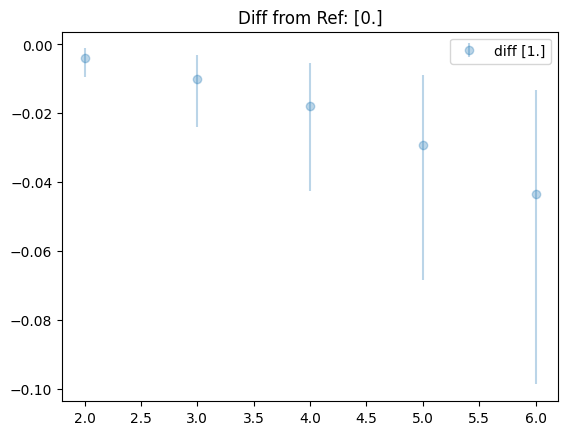

In [437]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])

Here we can see the measure of avg difference between the mean value across draws for each patient from the reference level and associated credible interval

By time 6 (1 year) there is an average predicted difference of -4% in SV probabilities. The 95% CI distribution of differences is between ~(-1%)-(-10%)    

Next get the expected difference. Plot the expected and predicted against each other for the marginal evaluations

In [438]:
# LAMBDA2 = "0.001 * np.exp(3+0.5*np.sin(np.pi*xxx[:,0]*xxx[:,1]) + np.power(xxx[:,2],2) + 0.5*xxx[:,3] + 0.25*xxx[:,4])" 
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)

array([[0.99711807, 0.99352733, 0.98852201, 0.98212364, 0.97435962],
       [0.99608563, 0.99121421, 0.98443422, 0.97578519, 0.96531728],
       [0.99799068, 0.9954847 , 0.9919869 , 0.98750778, 0.98206075],
       ...,
       [0.98442617, 0.96921199, 0.95028089, 0.92818501, 0.90338835],
       [0.99130991, 0.98276136, 0.97204071, 0.9594072 , 0.94506943],
       [0.99042559, 0.98101551, 0.96922624, 0.95535052, 0.93962557]])

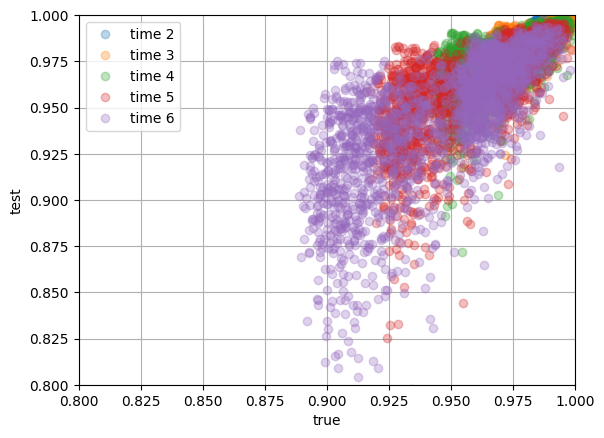

In [439]:
# check how the predictions compare
for i in np.arange(0,len(TIMES)):
    plt.plot(ooo[:,i], bart_sv_fx[:,i], "o", alpha=0.3, label = f"time {TIMES[i]}" )
plt.ylabel("test")
plt.xlabel("true")
plt.legend()
plt.xlim(0.8,1)
plt.ylim(0.8,1)
plt.grid(visible=True)


Predictions and True expectations align fairly well over the Time points values. 

There appears to be some bias in predictions to being slightly lower than expected. However the major proportion of predictions are within the body of the expected values.

The bias is most prevalent at the timepoint 6.

Plot the marginal difference plots and 95% CI distributions for the expected and predicted

(5,)
(5,)


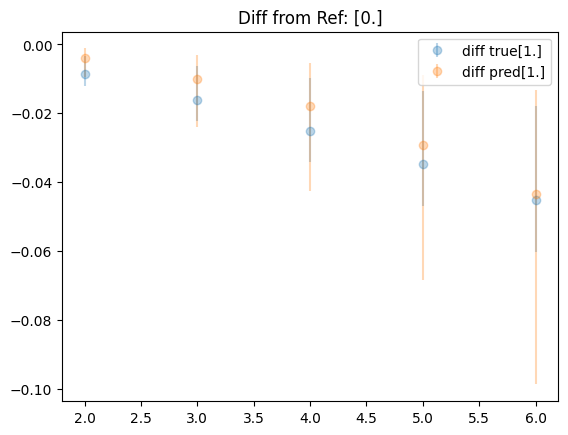

In [440]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

The expected and predicted mean marginal differnce is approximate to each other. The CI for the predicted outcomes is wider than the true interval, but the alignment of mean values is a positive sign.

With these results I think we can say that given similar Dataset conditions we can move forward with the method.

## Relative Risk Comparison

# Quick check the other variables

In [445]:
LAMBDA

'np.exp(-8.4 + 0.2*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.01*np.log(x_mat[:,1])  + 0.001*np.power(x_mat[:,2],2) + 0.09*(x_mat[:,3]*x_mat[:,4]))'

VAR 2

Sampling: [f, y_pred]


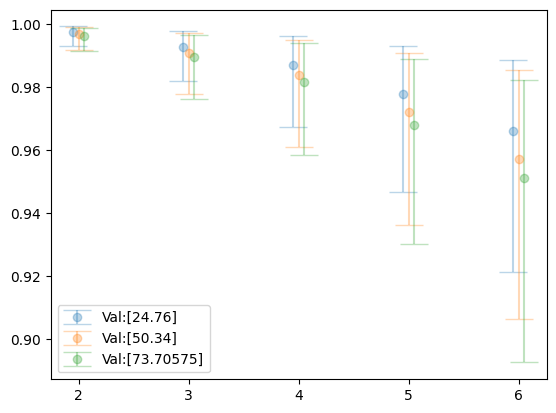

In [441]:
VAR=2
TIMES = [2,3,4,5,6]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(5,)
(5,)
(5,)
(5,)


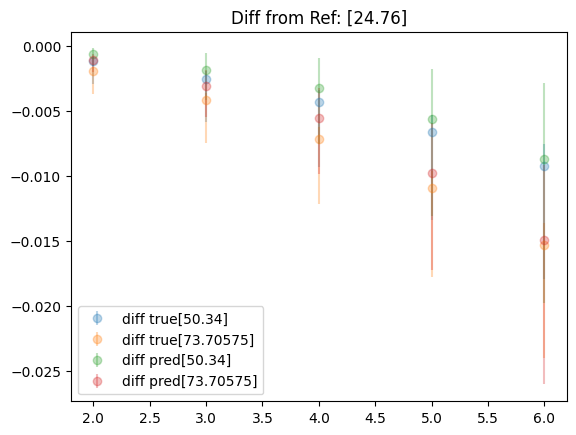

In [442]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
# plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 3

Sampling: [f, y_pred]


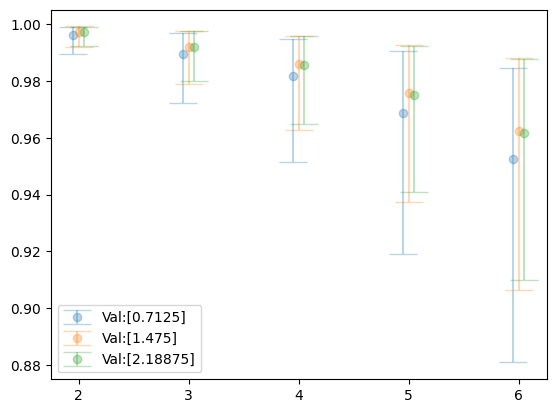

In [443]:
VAR=3
TIMES = [2,3,4,5,6]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(5,)
(5,)
(5,)
(5,)


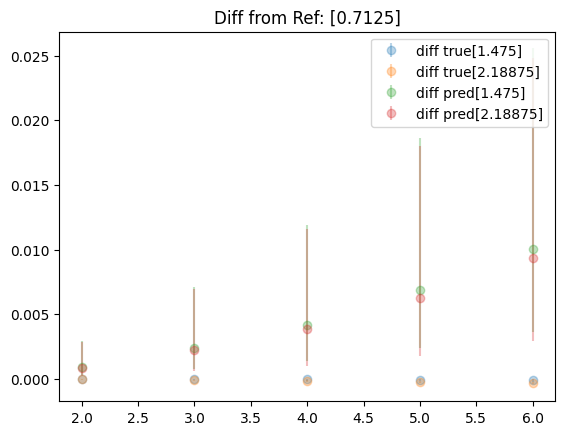

In [444]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
# plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 4

Sampling: [f, y_pred]


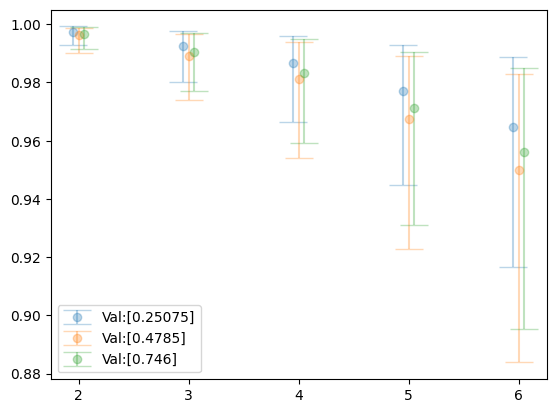

In [446]:
VAR=4
TIMES = [2,3,4,5,6]
RN = 1000
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(5,)
(5,)
(5,)
(5,)


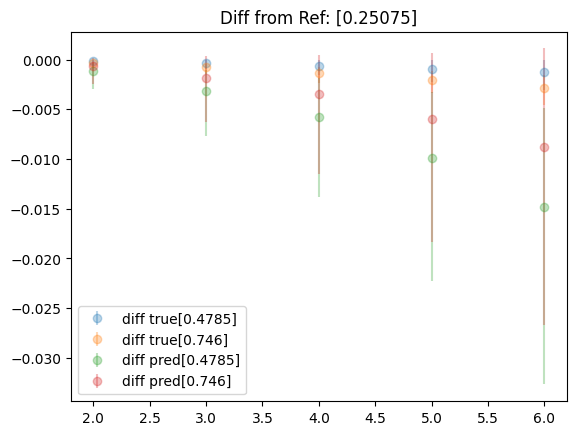

In [447]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
# plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Val 5

Sampling: [f, y_pred]


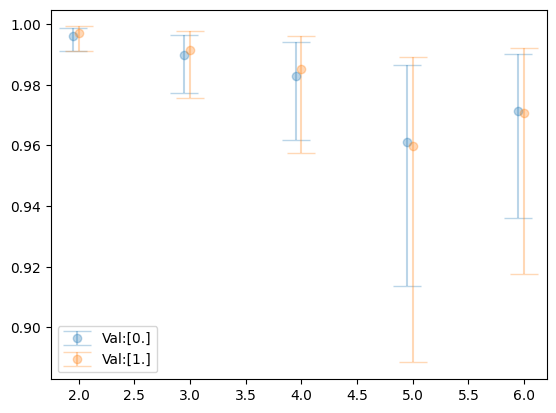

In [450]:
VAR=5
TIMES = [2,3,4,6,5]
RN = 400
VAL = [0, 1]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(5,)
(5,)


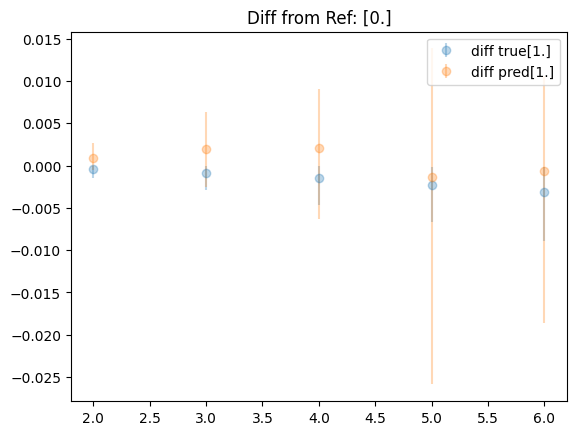

In [453]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
# plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 6

Sampling: [f, y_pred]


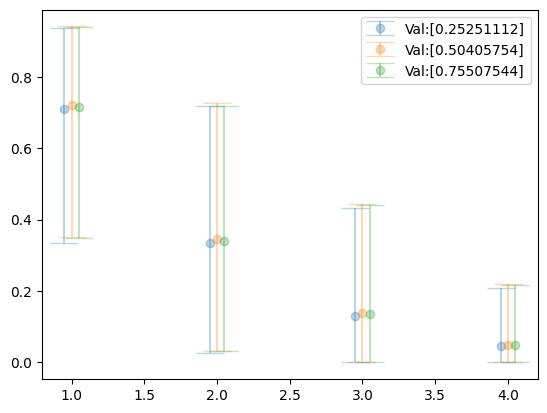

In [416]:
VAR=6
TIMES = [2,3,4,5,6]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

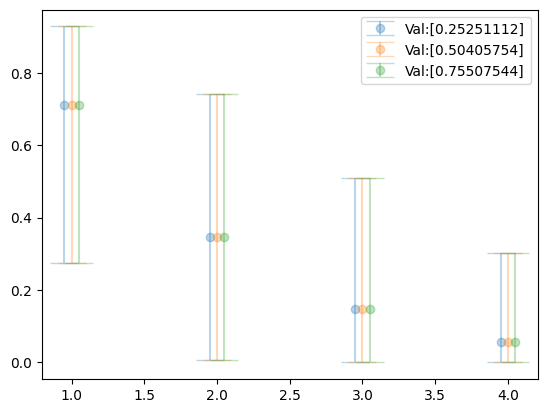

In [417]:
ooo = get_true_sv(lmbda = LAMBDA, a=2, pdp_l = pdp_l, TIMES=TIMES)
svplot(ooo, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(4,)
(4,)
(4,)
(4,)


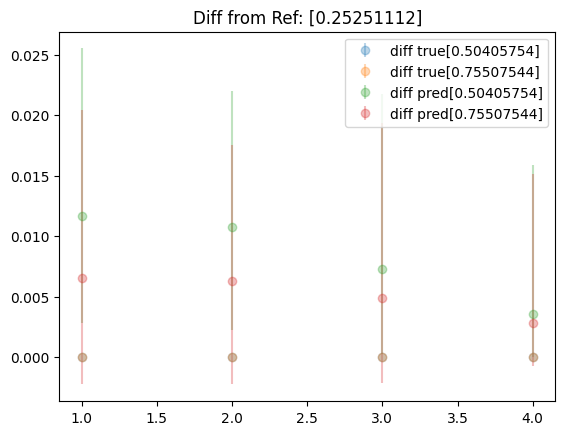

In [418]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 6 in not incorporated into the DGP and its difference should be 0. The observed difference is less at most ~0.01, indicaating that the model did a fairly good job in not producing a high difference value on this valiable.